In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import numpy as np

# Data Import and Preparation

In [2]:
data_df = pd.read_excel('Stepwise_JJ.xlsx', index_col=0,sheet_name="Python Data", engine="openpyxl")
data_df.head(1)

,RoE Japan,Leading Indicator YoY,Leading Indicator 3M/12M,Leading Indicator YoY Smoothed,Leading Indicator 3M/12M Smoothed,OECD Leading Indicator YoY,OECD Leading Indicator 3M/12M,OECD Leading Indicator YoY Smoothed,OECD Leading Indicator 3M/12M Smoothed,G7 Leading Indicator YoY,...,Oil Prices YoY,Oil Prices 3M/12M,Oil Prices YoY Smoothed,Oil Prices 3M/12M Smoothed,JPN Trade Weighted YoY,JPN Trade Weighted 3M/12M,JPN Trade Weighted YoY Smoothed,JPN Trade Weighted 3M/12M Smoothed,JPN Trade Weighted Index,JPN Trade Weighted Index Smoothed
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-14,3.86,0.0,0.002044,0.006867,0.008281,-0.002141,-0.002108,-0.001673,-0.001907,-0.012438,...,-0.118915,-0.012868,-0.193842,-0.051584,-0.076646,-0.058763,-0.063489,-0.0588,-110.7047,-110.192967


# Data Overview

In [77]:
def regression_plots(regression_data_df = data_df, y_variable = "RoE Japan", columns = 3):
    rows = int(np.ceil((len(regression_data_df.columns)-1)/columns))
    fig,axs = plt.subplots(rows,columns, sharey=True,figsize = (rows*4,rows*4))
    for col,ax in enumerate(axs.flatten()):
        if col <len(regression_data_df.columns):
            column = regression_data_df.columns[col]
            if column == y_variable:
                continue
            else:
                sns.regplot(x = regression_data_df[column],y=regression_data_df[y_variable],ax=ax,robust=False)
    fig.tight_layout()

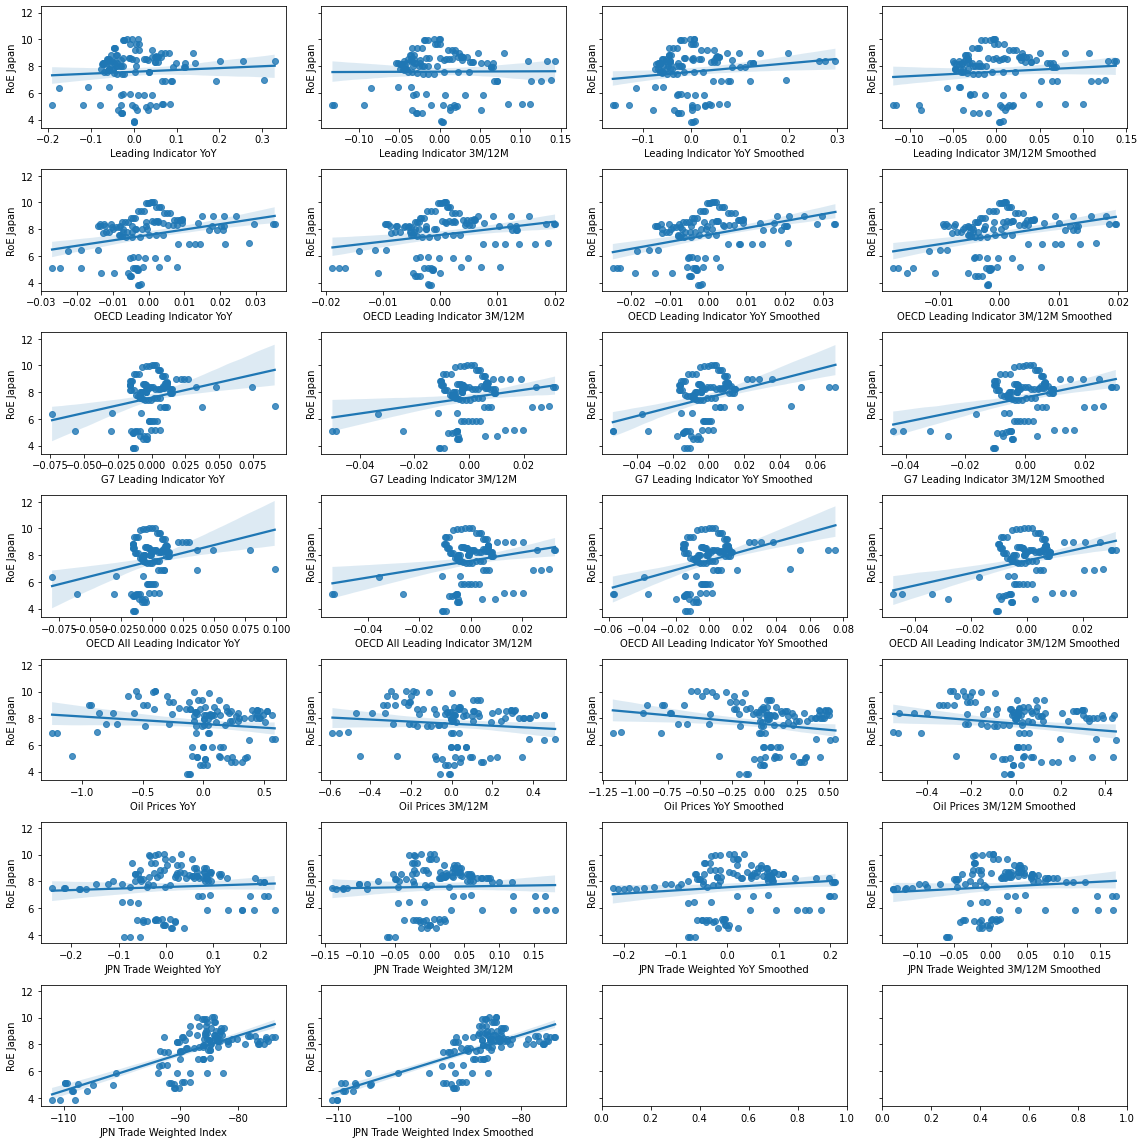

In [3]:
columns = 4
rows = int(np.ceil((len(data_df.columns)-1)/columns))
fig,axs = plt.subplots(rows,columns, sharey=True,figsize = (16,16))
for col,ax in enumerate(axs.flatten()):
    if col+1 <len(data_df.columns):
        column = data_df.columns[col+1]
        #print(data_df[column].head(2))
        sns.regplot(x = data_df[column],y=data_df["RoE Japan"],ax=ax,robust=False)
fig.tight_layout()

# Stepwise Regression

In [88]:
def stepwise_regression(regression_data_df = data_df, y_variable = "RoE Japan",constant = True, max_p = 0.05,only_positive=True):
    '''
    This function iterates over the given data frame, trying to explain the y variable by all variables except iteself.
    The process stops once all variables are below the specified p-value. 
    By default only positive coefficients are accepted. Model filters until no negative coefficients are in the regression anymore.
    '''
    
    #Set Original Dataframe
    X = regression_data_df
    X = X.drop([y_variable],axis=1)
    if constant == True:
        X = sm.add_constant(X)
    Y = regression_data_df[y_variable]
    exog_vars = len(X.columns)
    
    #Iterate
    while exog_vars >2:
        model = sm.OLS(endog = Y, exog = X)
        results = model.fit()
        
        worst_p_value = results.pvalues.max()
        worst_p_name = results.pvalues.idxmax()
        X = X.drop([worst_p_name],axis=1)
        exog_vars = len(X.columns)
        if worst_p_value<max_p:
            break

    model = sm.OLS(endog = Y, exog = X)
    results = model.fit()
    params_inc_neg = results.params
    
    if only_positive==True:         
        while len(results.params[results.params<0])>0:
            coeffs = results.params
            coeffs_pos = coeffs[coeffs>0]
            X = X[coeffs_pos.index.to_list()]
            model = sm.OLS(endog = Y, exog = X)
            results = model.fit()

    relevant_vars = regression_data_df[X.columns.drop("const").to_list()+[y_variable]]
    return results, relevant_vars,params_inc_neg


In [92]:
stepwise_regression(regression_data_df = data_df, y_variable = "RoE Japan",constant = True, max_p = 0.05,only_positive=True)[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              RoE Japan   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     81.04
Date:                Sun, 16 Jan 2022   Prob (F-statistic):           7.11e-23
Time:                        12:37:21   Log-Likelihood:                -174.96
No. Observations:                 121   AIC:                             355.9
Df Residuals:                     118   BIC:                             364.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                      19.1129      1.062     18.000      0.000      17.010      21.216
OECD All Leading Indicator YoY Smoothed    14.4931      5.635      2.572      0.011       3.335      25.651
JPN Trade Weighted Index Smoothed           0.1310      0.012     10.887      0.000       0.107       0.155
==============================================================================
Omnibus:                        0.021   Durbin-Watson:                   0.141
Prob(Omnibus):                  0.990   Jarque-Bera (JB):                0.096
Skew:                          -0.030   Prob(JB):                        0.953
Kurtosis:                       2.876   Cond. No.                     5.27e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.27e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [93]:
filtered_var_df = stepwise_regression(regression_data_df = data_df, y_variable = "RoE Japan",constant = True, max_p = 0.05)[1]
filtered_var_df.head(2)

,OECD All Leading Indicator YoY Smoothed,JPN Trade Weighted Index Smoothed,RoE Japan
Date,,,
2012-01-14,-0.011570,-110.192967,3.86
2012-02-14,-0.013303,-110.989767,3.81


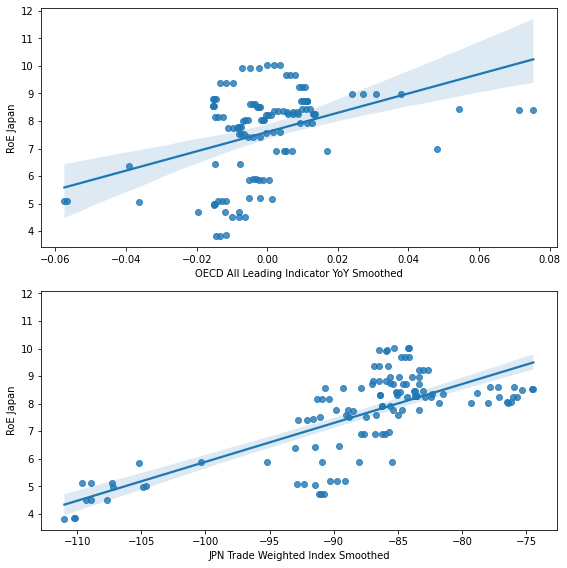

In [94]:
regression_plots(regression_data_df = filtered_var_df, y_variable = "RoE Japan", columns = 1)